<a href="https://colab.research.google.com/github/joeyMckinney/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/josiah_mckinney_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

#import data

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [115]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [116]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#wrangle/split

In [120]:
import numpy as np

#this function will clean up data. droping features with high cardinality and
#replacing lat and log values with 0s to nan.then it splits the data
def wrangle_split(train, test):

  train_c = train.copy()
  test_c = test.copy()

  #change bad latitute measurements with 0
  train_c['latitude'] = train_c['latitude'].replace(-2e-08, 0)
  test_c['latitude'] = test_c['latitude'].replace(-2e-08, 0)
  
  #remove outliers
  train_c = train_c[(train_c['latitude'] >= np.percentile(train_c['latitude'], 0.05)) & 
        (train_c['latitude'] < np.percentile(train_c['latitude'], 99.95)) &
        (train_c['longitude'] >= np.percentile(train_c['longitude'], 0.05)) & 
        (train_c['longitude'] <= np.percentile(train_c['longitude'], 99.95))]
  

  #change all the latitude and longitude values that are 0 with nan
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
     train_c[col] = train_c[col].replace(0, np.nan)
     test_c[col] = test_c[col].replace(0, np.nan)

  #get rid of features with high cardinality
  hc_cols_train = [col for col in train_c.describe(include='object').columns 
             if train_c[col].nunique() > 100]
  hc_cols_test = [col for col in test_c.describe(include='object').columns 
             if test_c[col].nunique() > 100]

  #Droping a repeated feature
  train_c = train_c.drop(['quantity_group'] + hc_cols_train, axis=1)
  test_c = test_c.drop(['quantity_group'] + hc_cols_test , axis=1)
  
  y = train_c['status_group']
  X = train_c.drop('status_group', axis=1)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

  return X_train, X_val, y_train, y_val, test_c

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
#applying the wrange split function to the data
X_train, X_val, y_train, y_val, test_c = wrangle_split(train, test)

#baseline

In [123]:
#baseline accuracy
baseline = y_train.value_counts(normalize=True).max()
baseline

0.5450871322411021

#model

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [125]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=77)
)

params = {'randomforestclassifier__n_estimators': range(1, 200, 10),
          'randomforestclassifier__max_depth': range(1,50)}

rs = RandomizedSearchCV(model, 
                        param_distributions=params, 
                        n_iter=10, 
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [126]:
rs.best_estimator_

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'w...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=31, max_features='auto',
                                  

In [127]:
model2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=31, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=171, n_jobs=None,
                                        oob_score=False, random_state=77,
                                        verbose=0, warm_start=False)
)
model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'w...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=31, max_features='auto',
                                  

In [128]:
train_accuracy = model2.score(X_train, y_train)
val_accuracy = model2.score(X_val, y_val)

print(train_accuracy)
print(val_accuracy)

0.9999782712615706
0.8087954110898662


#plot confusion matrix

In [129]:
from sklearn.metrics import plot_confusion_matrix, classification_report

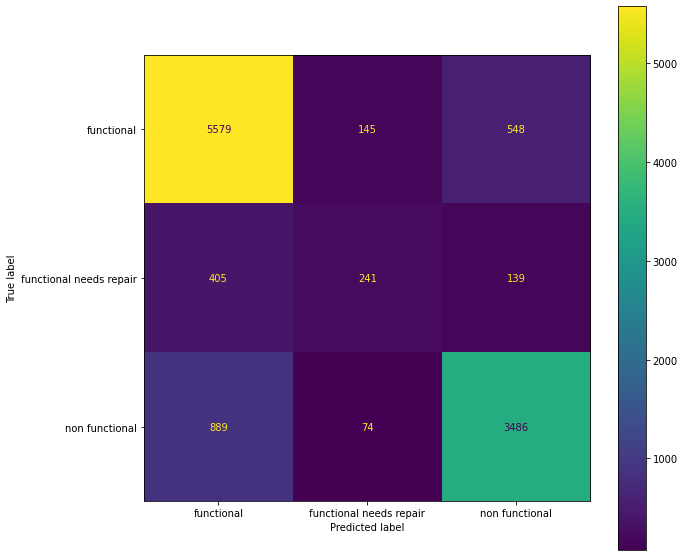

In [142]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model2, X_val, y_val, 
                      values_format=".0f", 
                      display_labels=['functional', 'functional needs repair', 'non functional'],
                      ax=ax);

In [143]:
print(classification_report(y_val, model2.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6272
functional needs repair       0.52      0.31      0.39       785
         non functional       0.84      0.78      0.81      4449

               accuracy                           0.81     11506
              macro avg       0.72      0.66      0.68     11506
           weighted avg       0.80      0.81      0.80     11506



In [144]:
y_val.value_counts(normalize=True)

functional                 0.545107
non functional             0.386668
functional needs repair    0.068225
Name: status_group, dtype: float64